<a href="https://colab.research.google.com/github/tobp03/project-RiskAssessment/blob/main/Scripts/Video%20augmentation%20test%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import dependencies

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 28.7 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import random
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import time
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path='/content/gdrive/MyDrive/Datasets'
os.listdir(path)
for i in os.listdir(path):
  print()

## Define functions

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
def video_to_uint8array(file_path):
    # Open the video file
    cap = cv2.VideoCapture(file_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    frames = []
    while True:
        ret, frame = cap.read()
        # If the video has finished or an error occurs, break the loop
        if not ret:
            break
        frame_array = np.array(frame)
        #Set output video resolution
        frame_array = cv2.resize(frame_array, (320, 240))
        frames.append(frame_array)

    # Release the video capture object and close the OpenCV window
    cap.release()
    cv2.destroyAllWindows()
    return np.array(frames)

def extract_to_array(results):
    pose_features = ['x','y','z','visibility']
    hand_features = ['x','y','z']
    features= []
    all_landmarks = np.zeros((21 * 2 + 33 , 3))
    if hasattr(results.pose_landmarks, 'landmark'):
        for i,value in enumerate(results.pose_landmarks.landmark):
            features.extend([f'pose_x{i}', f'pose_y{i}',f'pose_z{i}'])
            all_landmarks[i] = [value.x,value.y,value.z]

    if hasattr(results.left_hand_landmarks, 'landmark'):
        for i,value in enumerate(results.left_hand_landmarks.landmark):
            features.extend([f'Lhand_x{i}', f'Lhand_y{i}',f'Lhand_z{i}'])
            all_landmarks[i+33] = [value.x,value.y,value.z]

    if hasattr(results.right_hand_landmarks, 'landmark'):
        for i,value in enumerate(results.right_hand_landmarks.landmark):
            features.extend([f'Rhand_x{i}', f'Rhand_y{i}',f'Rhand_z{i}'])
            all_landmarks[i+54] = [value.x,value.y,value.z]

    return features , all_landmarks

def vidarray_to_keyMP(video):
  temp = []
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5,model_complexity=0) as holistic:
    for frame_num in range(video.shape[0]):
      _, results = mediapipe_detection(video[frame_num], holistic)
      features, data=extract_to_array(results)
      temp.append(data)
    return np.array(temp)

In [ ]:
# For plotting
def plot2d(array_vid,video):
  import numpy as np
  import matplotlib.pyplot as plt

  # Assuming you have a variable array_vid containing your data
  data = array_vid

  # Normalize the data based on the width and height of the image
  normalized_data = data * np.array([video.shape[1], video.shape[0], 1])

  # Create a plot
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(cv2.cvtColor(video, cv2.COLOR_BGR2RGB))

  # Overlay points on top of the image
  # Points with index 0 to 31 will be red, the rest will be green
  ax.scatter(normalized_data[:32, 0], normalized_data[:32, 1], color='red', marker='o', s=2, label='Red Points')
  ax.scatter(normalized_data[33:, 0], normalized_data[33:, 1], color='green', marker='o', s=2, label='Green Points')

  # Set labels
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')


  # Show the plot
  plt.show()

def plot3d(array_vid):
  import plotly.graph_objects as go
  import numpy as np

  # Assuming you have a variable array_vid containing your data
  data = array_vid

  # Extract x, y, and z coordinates from data
  x = data[:, 0]
  y = data[:, 1]
  z = data[:, 2]

  # Import required class (if using older Plotly versions)
  from plotly.graph_objs import Scatter3d  # Uncomment if using Plotly < v4.0.0

  # Create lines based on MediaPipe connections
  lines = []
  for connection in mp_holistic.POSE_CONNECTIONS:
      start_index, end_index = connection
      start_x, start_y, start_z = x[start_index], y[start_index], z[start_index]
      end_x, end_y, end_z = x[end_index], y[end_index], z[end_index]

      # Use Scatter3d or appropriate class based on Plotly version
      line_obj = Scatter3d(  # Use this for Plotly v4.0.0 and later
          x=[start_x, end_x],
          y=[start_y, end_y],
          z=[start_z, end_z],
          mode='lines',
          line=dict(color='red')
      )
      # Uncomment for older Plotly versions (replace 'Scatter3d' with actual class)
      # line_obj = Scatter3d(  # Replace with the appropriate class
      #     x=[start_x, end_x],
      #     y=[start_y, end_y],
      #     z=[start_z, end_z],
      #     mode='lines',
      #     line=dict(color='red')
      # )

      lines.append(line_obj)

  # Create the scatter plot
  scatter = go.Scatter3d(
      x=x,
      y=y,
      z=z,
      mode='markers',
      marker=dict(size=5)
  )

  # Combine scatter plot and lines
  fig = go.Figure(data=[scatter] + lines)  # Add lines to the figure

  # Set axis labels
  fig.update_layout(scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'))

  # Show the plot
  fig.show()


def plot3d_video(array_vid):
  import plotly.graph_objects as go
  from plotly.subplots import make_subplots
  import numpy as np

  # Assuming you have a variable array_vid containing your data
  # Note: Make sure array_vid is a list containing the 30 frames

  # Define the number of frames
  num_frames = len(array_vid)

  # Create subplots
  fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

  # Create lines based on MediaPipe connections for the initial frame
  lines = []
  for connection in mp_holistic.POSE_CONNECTIONS:
      start_index, end_index = connection
      start_x, start_y, start_z = array_vid[0][start_index]
      end_x, end_y, end_z = array_vid[0][end_index]

      line_obj = go.Scatter3d(
          x=[start_x, end_x],
          y=[start_y, end_y],
          z=[start_z, end_z],
          mode='lines',
          line=dict(color='red', width=2)  # Set line color to red and width to 2
      )

      lines.append(line_obj)

  # Add lines to the initial frame
  fig.add_traces(lines)

  # Set axis labels
  fig.update_layout(scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'))

  # Define frames
  frames = [go.Frame(
      data=[
          # Update scatter plot for each frame
          go.Scatter3d(
              x=array_vid[frame_idx][:, 0],
              y=array_vid[frame_idx][:, 1],
              z=array_vid[frame_idx][:, 2],
              mode='markers',
              marker=dict(size=5, color='blue')  # Set marker color to blue
          )
      ] +
      [
          # Update lines for each frame
          go.Scatter3d(
              x=[array_vid[frame_idx][start_index, 0], array_vid[frame_idx][end_index, 0]],
              y=[array_vid[frame_idx][start_index, 1], array_vid[frame_idx][end_index, 1]],
              z=[array_vid[frame_idx][start_index, 2], array_vid[frame_idx][end_index, 2]],
              mode='lines',
              line=dict(color='red', width=2)  # Set line color to red and width to 2
          ) for start_index, end_index in mp_holistic.POSE_CONNECTIONS
      ]
  ) for frame_idx in range(num_frames)]

  # Add frames to the figure
  fig.frames = frames

  # Define animation settings
  animation_settings = dict(frame=dict(duration=500, redraw=True), fromcurrent=True)

  # Update layout with animation settings
  fig.update_layout(updatemenus=[dict(type='buttons', showactive=False, buttons=[dict(label='Play',
                                              method='animate', args=[None, animation_settings])])])

  # Show the plot
  fig.show()

# Analyze processed **'Hello' videos** by mediapipe

## Extract Videos from Google Drive

In [ ]:
# Path for exisiting data in google drive
gdrive_path = '/content/gdrive/MyDrive/Datasets'

# Recorded actions
actions = np.array(['hello', 'thanks', 'iloveyou','yes','no','help'])

# Amount of videos
no_sequences = 40

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [ ]:
#Create a new folder for augmented video
path = '/content/dataset'
for action in actions:
    try:
        path1 = os.path.join(path, str(action))
        os.mkdir(path1)
    except:
        print(f'The file \'{action}\' has be created already')
        pass

The file 'hello' has be created already
The file 'thanks' has be created already
The file 'iloveyou' has be created already
The file 'yes' has be created already
The file 'no' has be created already
The file 'help' has be created already


In [ ]:
X =[]
y= []
for seq in range(0,no_sequences):
  file_path = os.path.join(gdrive_path, actions[0], f'video hello {seq}.mp4')
  print(file_path)
  temp_video=video_to_uint8array(file_path)
  print(temp_video.shape)
  X.append(temp_video)
  y.append(action)
X = np.stack(X)
y = np.array(y)

/content/gdrive/MyDrive/Datasets/hello/video hello 0.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 1.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 2.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 3.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 4.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 5.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 6.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 7.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 8.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 9.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 10.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 11.mp4
(30, 240, 320, 3)
/content/gdrive/MyDrive/Datasets/hello/video hello 12.mp4
(30, 240, 320, 3)
/content/gdrive/MyDriv

In [ ]:
X.shape , y.shape

((40, 30, 240, 320, 3), (40,))

In [ ]:
X_temp =[]
for item in X:
  X_temp.append(vidarray_to_keyMP(item))
X_mpkeys = X_temp
X_mpkeys = np.stack(X_mpkeys)

In [ ]:
X_mpkeys = X_temp
X_mpkeys = np.stack(X_mpkeys)

In [ ]:
X_mpkeys.shape

(40, 30, 75, 3)

## Plot landmark distribution

In [ ]:
def plot_xyzDist(arrayX,arrayY,arrayZ):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 3, 1)
  plt.hist(arrayX, bins=30, color='blue', alpha=0.7)
  plt.title('X-Distribution')

  plt.subplot(1, 3, 2)
  plt.hist(arrayY, bins=30, color='green', alpha=0.7)
  plt.title('Y-Distribution')

  plt.subplot(1, 3, 3)
  plt.hist(arrayZ, bins=30, color='red', alpha=0.7)
  plt.title('Z-Distribution')

  plt.tight_layout()
  plt.show()

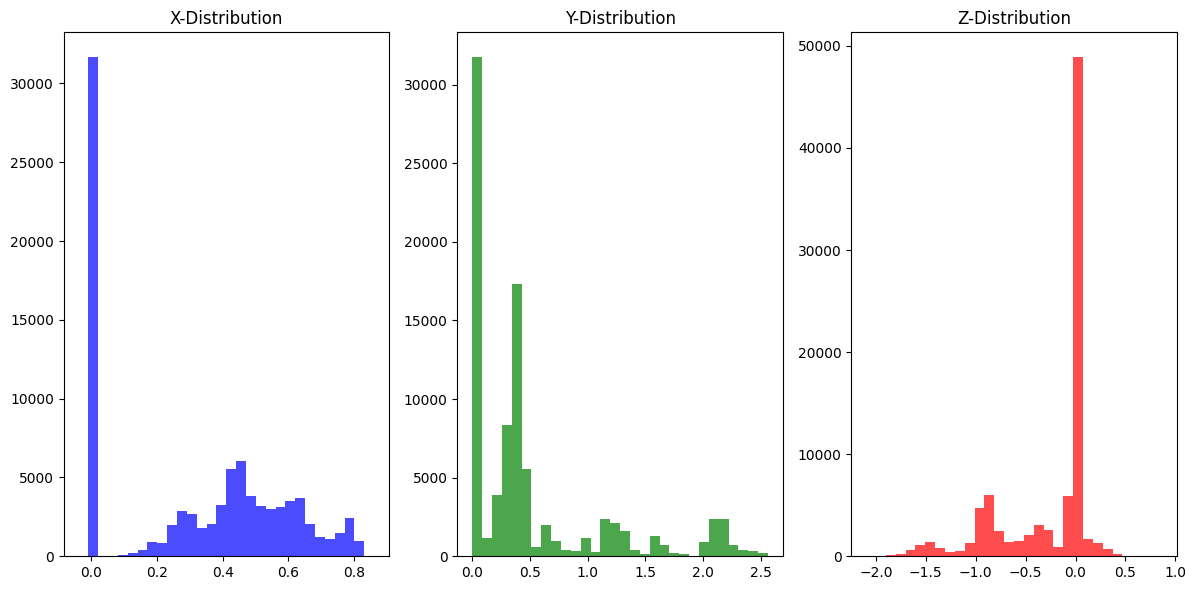

In [ ]:
# Distribution of every video, every frame by x, y, and z coordinate
mpkeys_cX = X_mpkeys[:,:,:,0].reshape(-1)
mpkeys_cY = X_mpkeys[:,:,:,1].reshape(-1)
mpkeys_cZ = X_mpkeys[:,:,:,2].reshape(-1)
plot_xyzDist(mpkeys_cX,mpkeys_cY,mpkeys_cZ)

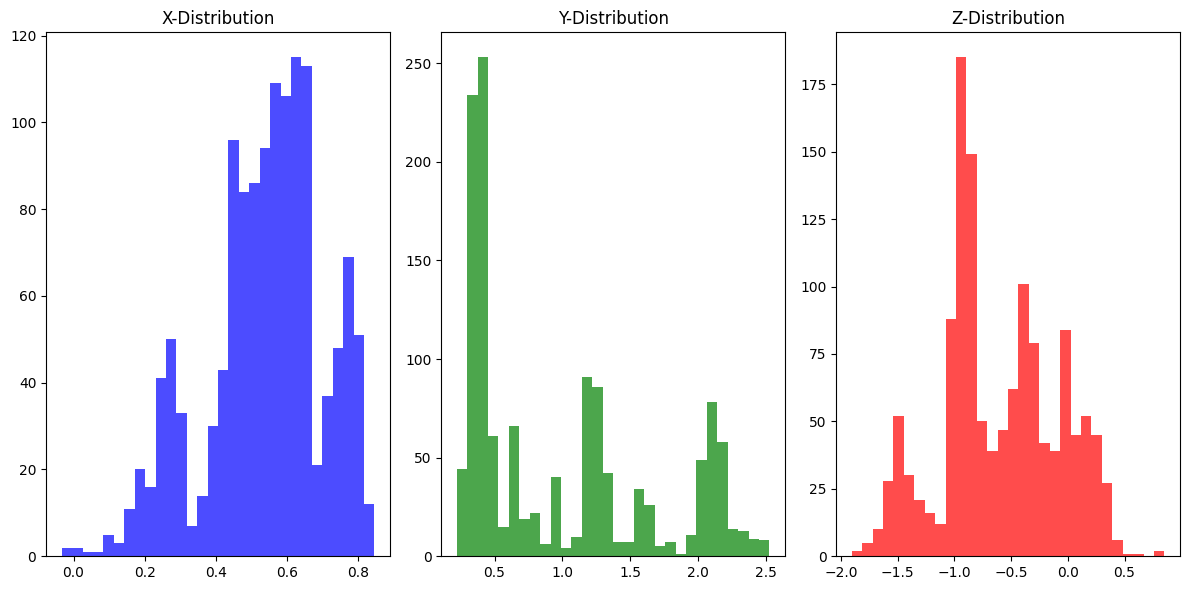

In [ ]:
# Distribution of every video, every frame by x, y, and z coordinate, but only pose landmarks
mpkeys_cX = X_mpkeys[:,0,:33,0].reshape(-1)
mpkeys_cY = X_mpkeys[:,0,:33,1].reshape(-1)
mpkeys_cZ = X_mpkeys[:,0,:33,2].reshape(-1)
plot_xyzDist(mpkeys_cX,mpkeys_cY,mpkeys_cZ)

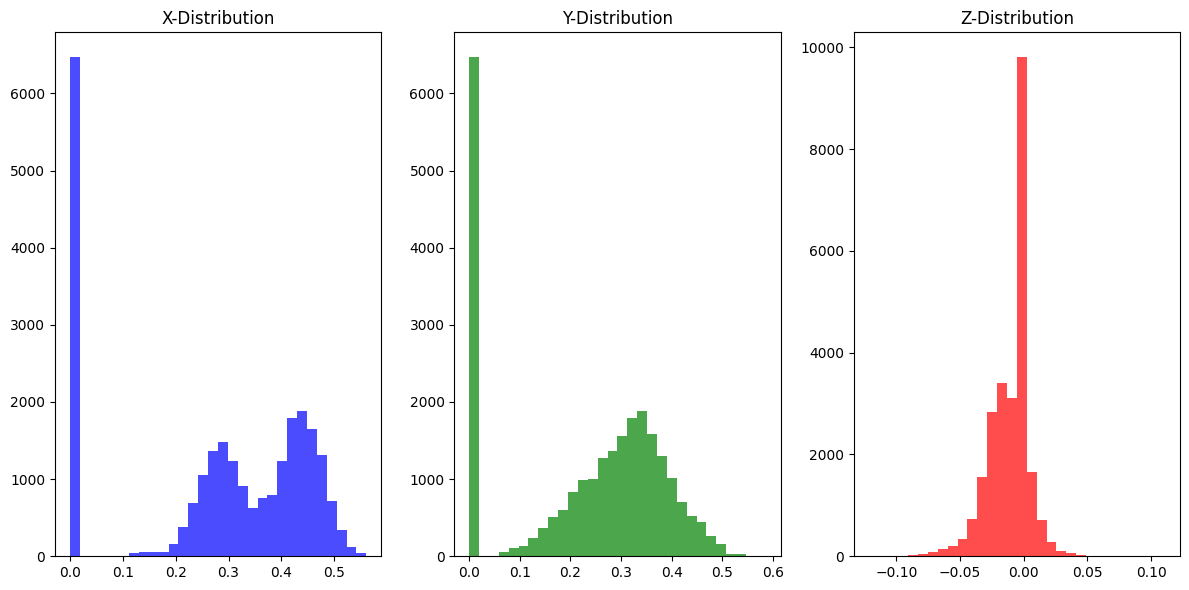

In [ ]:
# Distribution of every video, every frame by x, y, and z coordinate, but only pose landmarks
mpkeys_cX = X_mpkeys[:,:,54:,0].reshape(-1)
mpkeys_cY = X_mpkeys[:,:,54:,1].reshape(-1)
mpkeys_cZ = X_mpkeys[:,:,54:,2].reshape(-1)
plot_xyzDist(mpkeys_cX,mpkeys_cY,mpkeys_cZ)

0


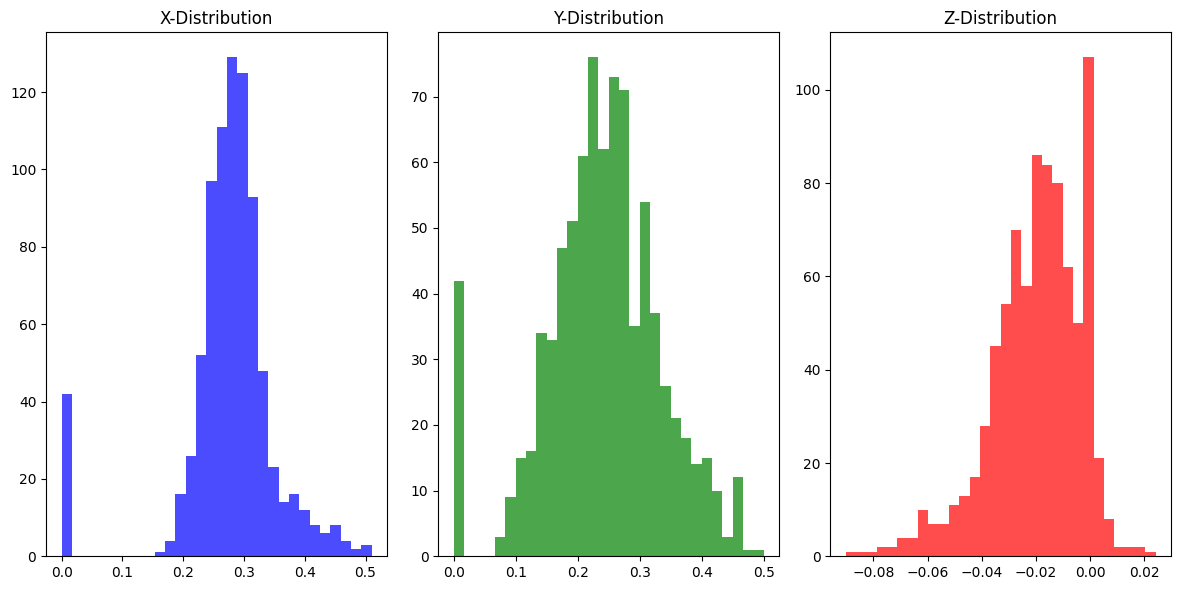

1


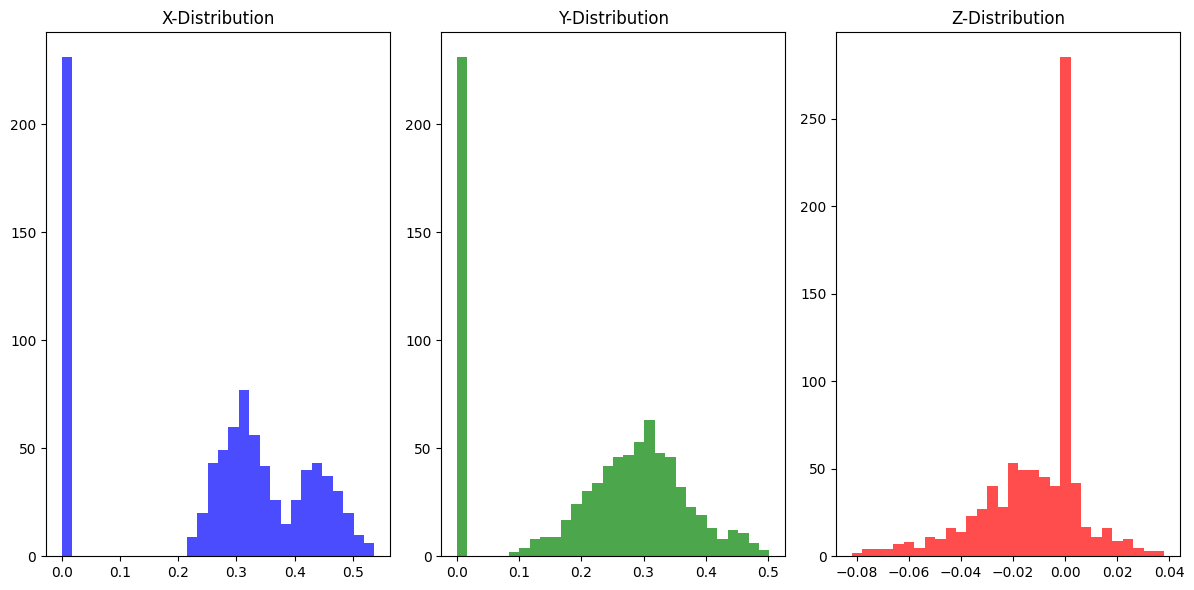

2


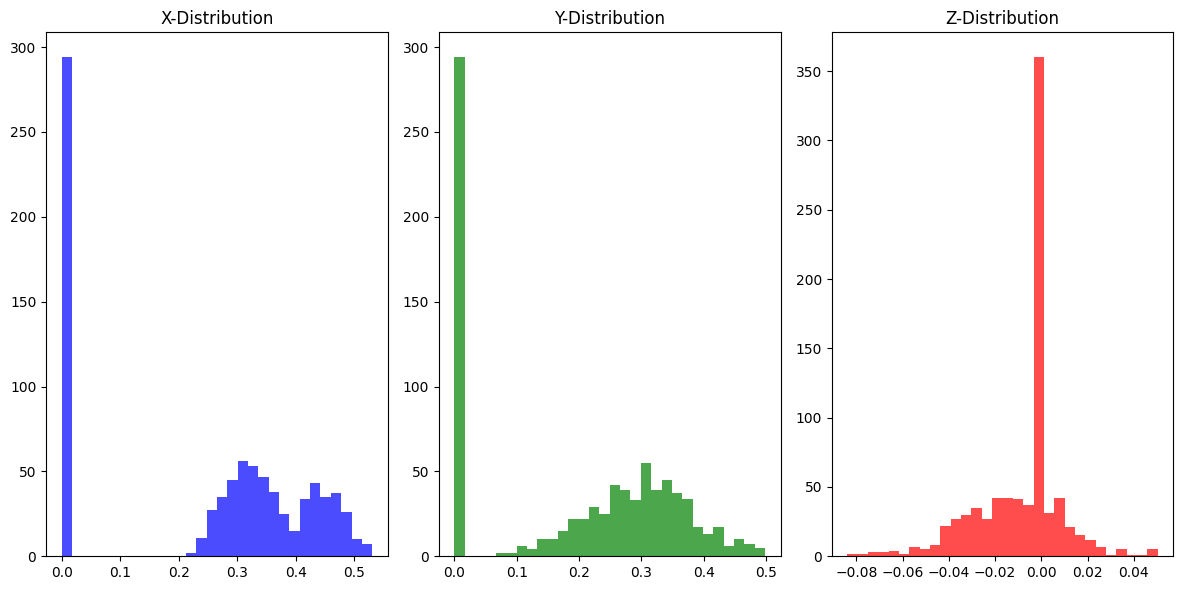

3


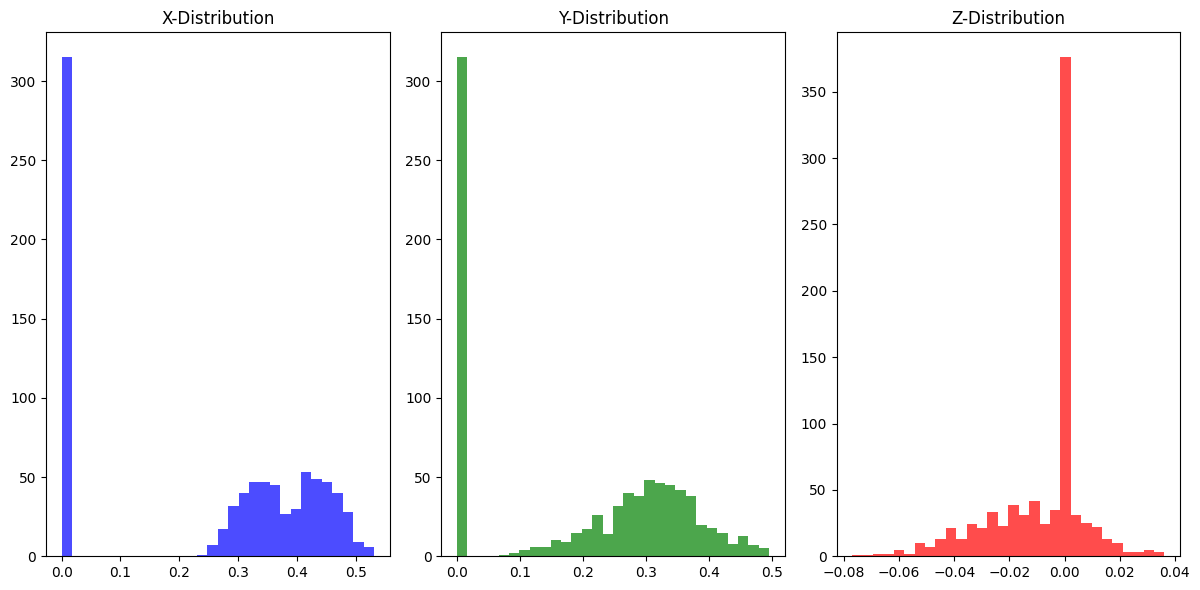

4


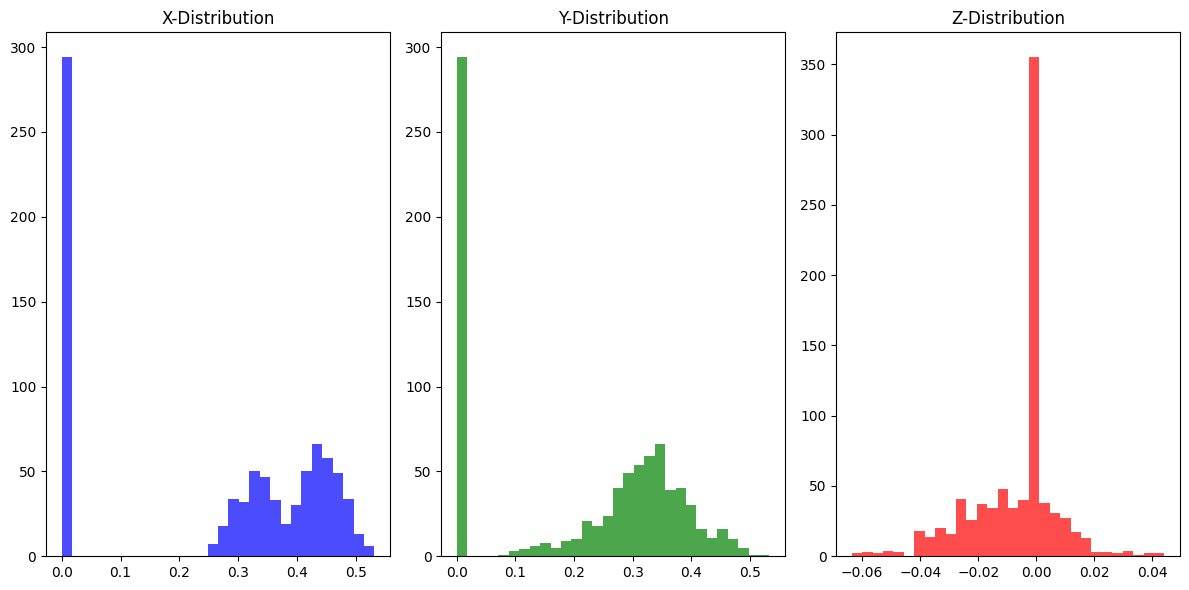

5


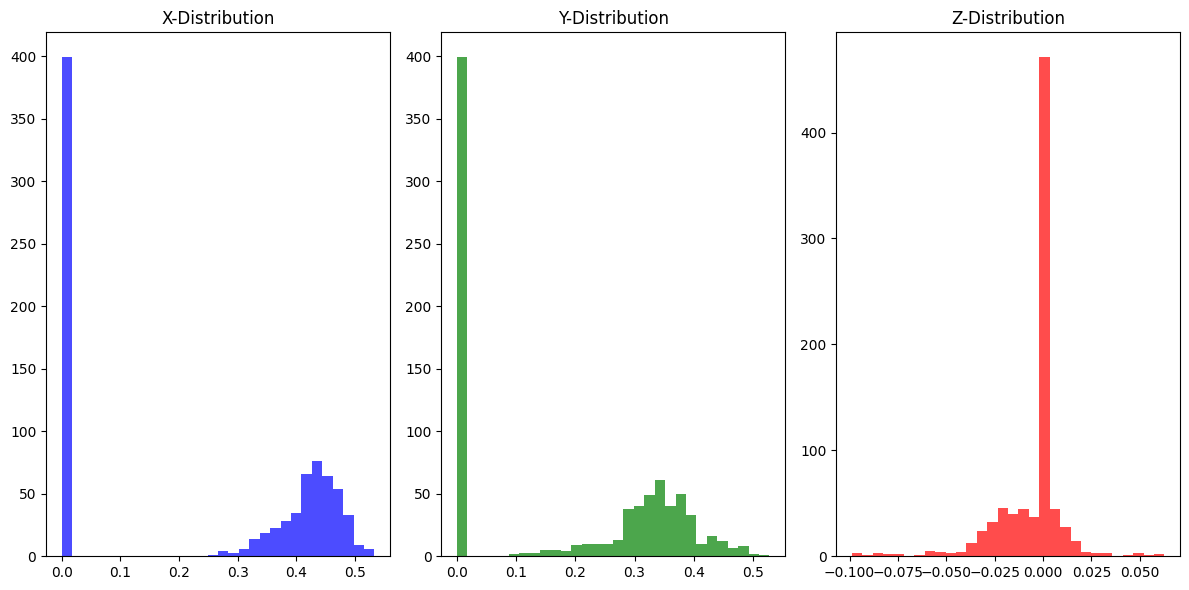

6


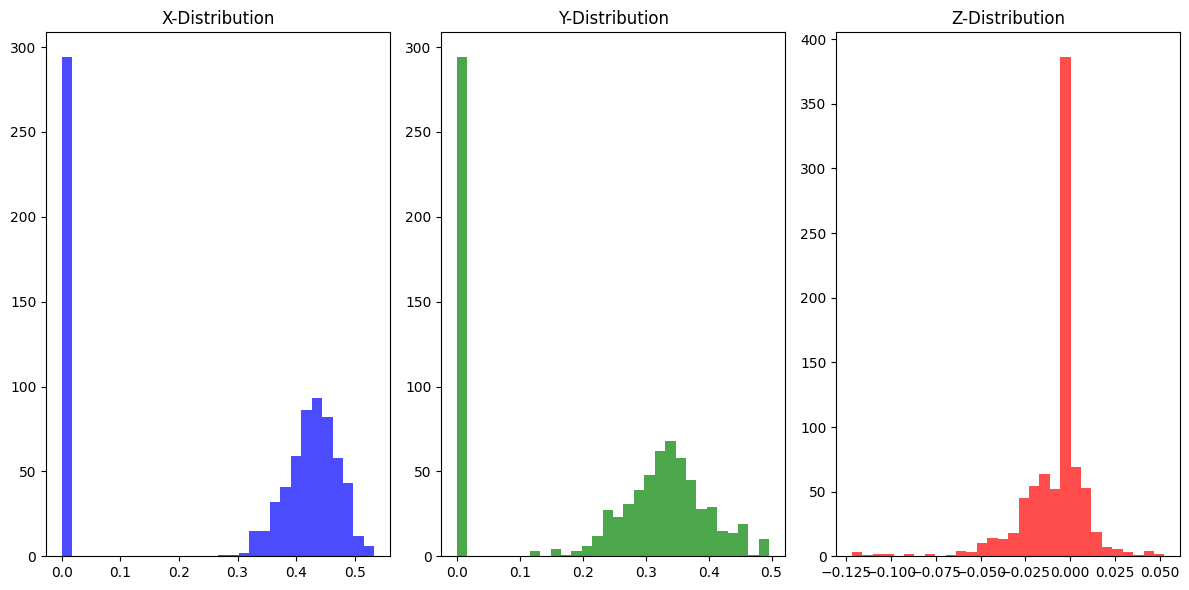

7


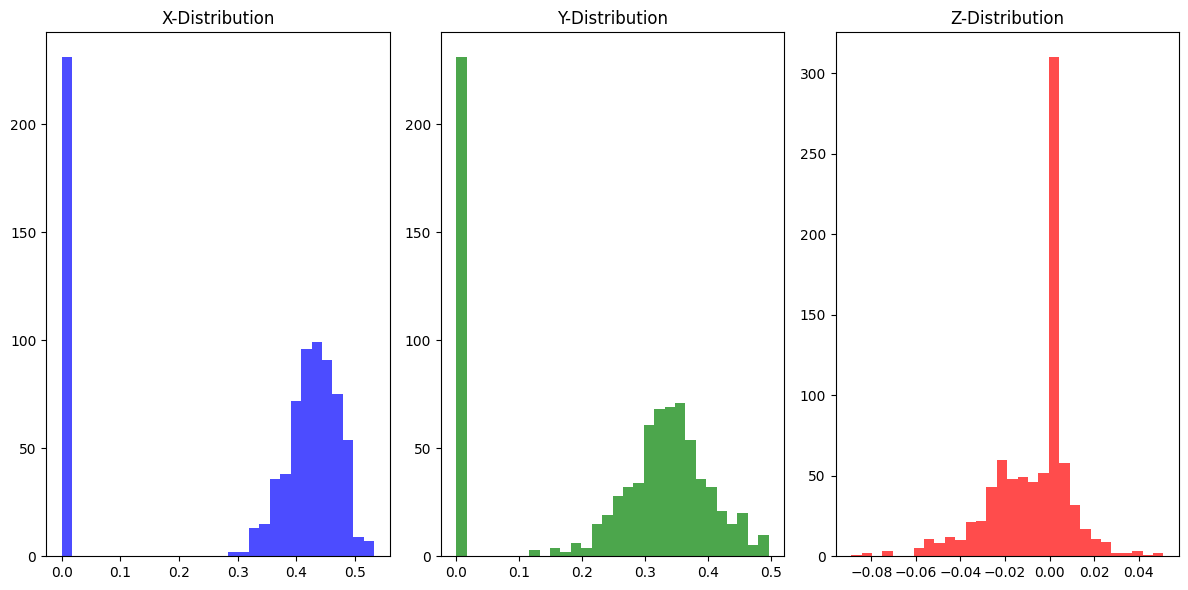

8


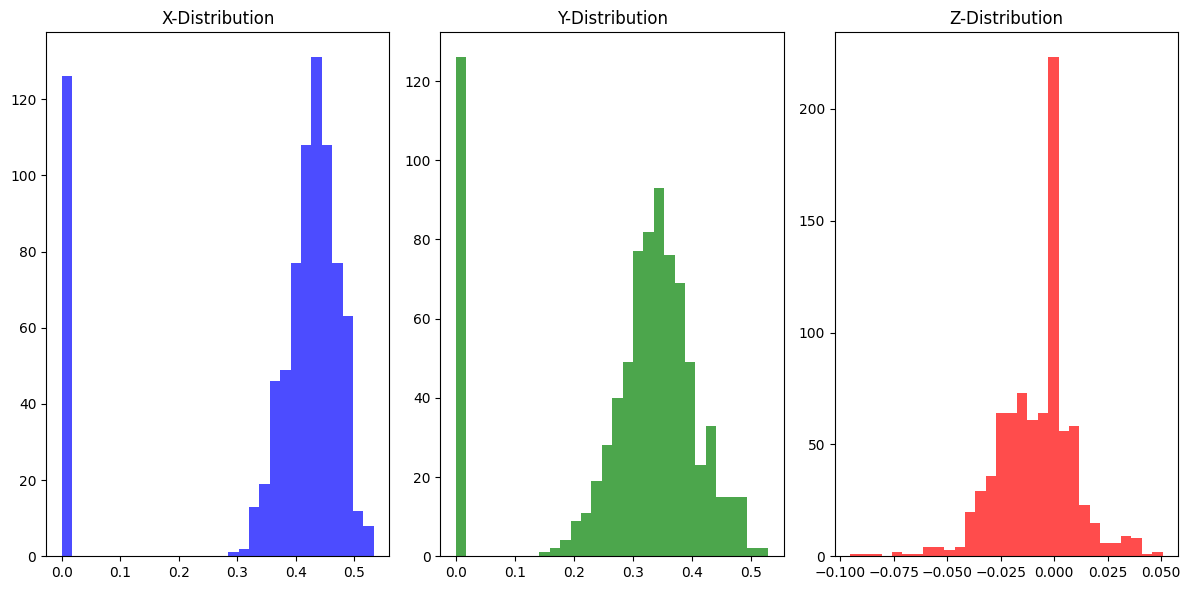

9


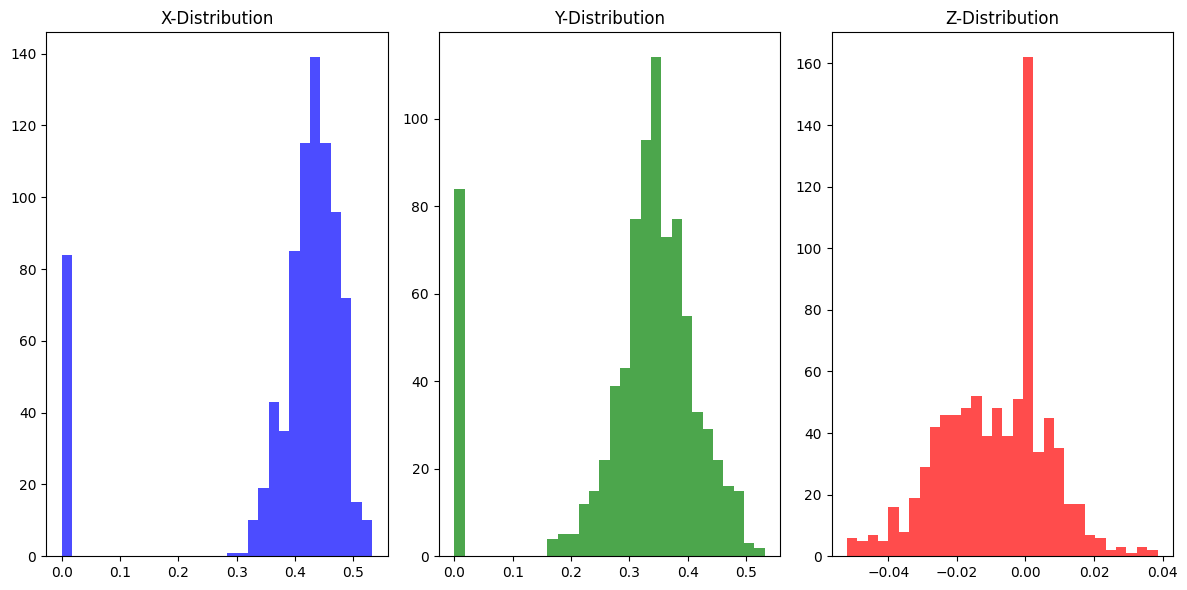

10


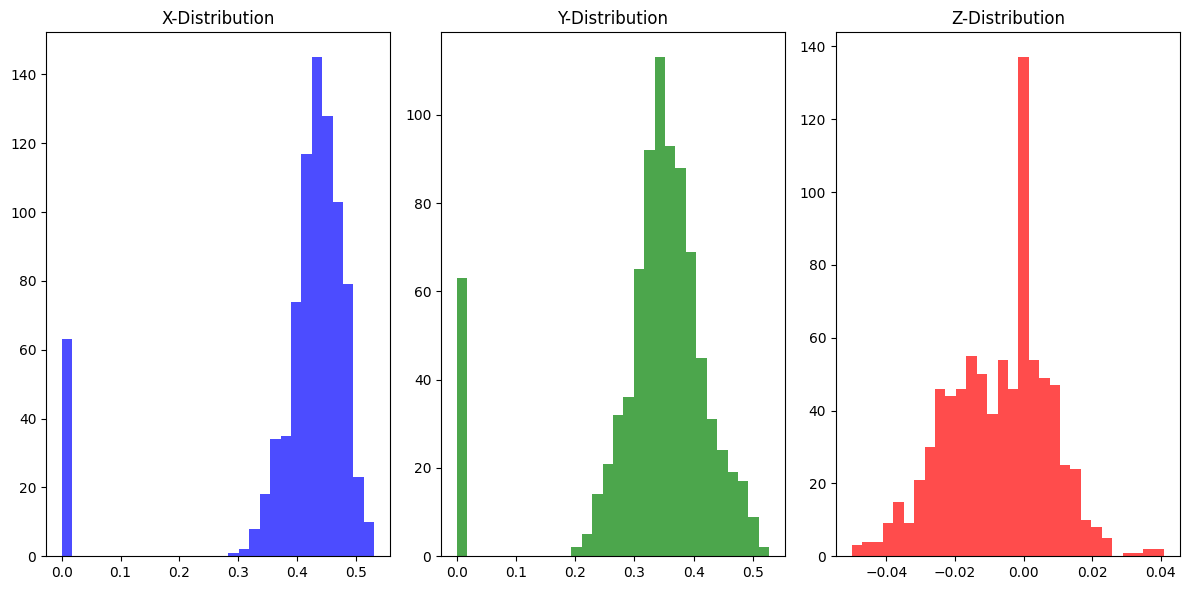

11


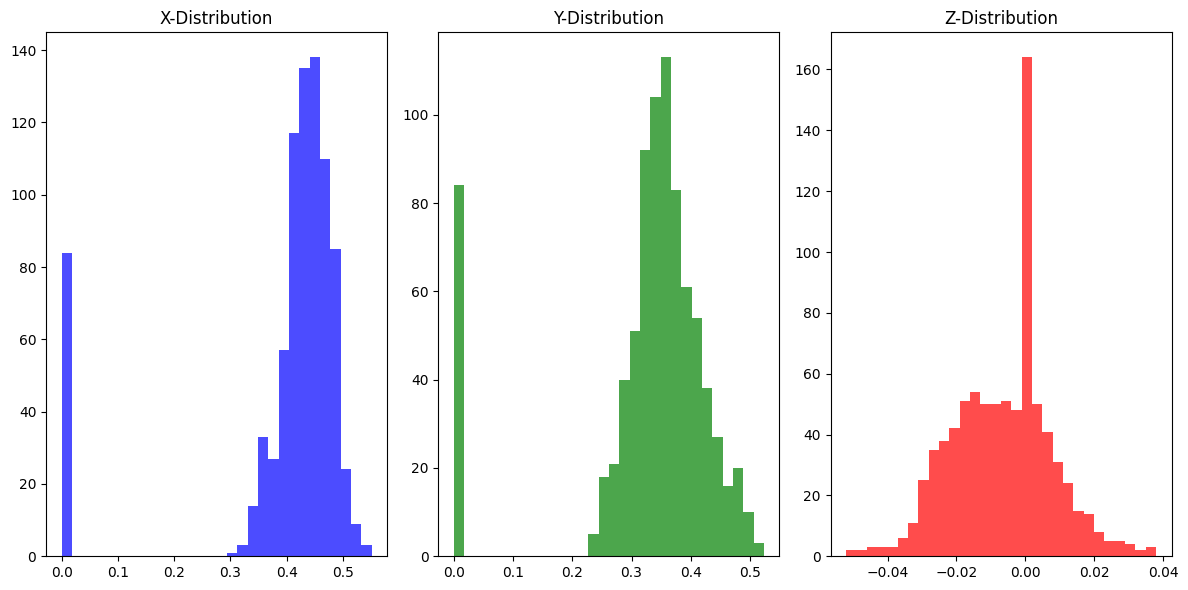

12


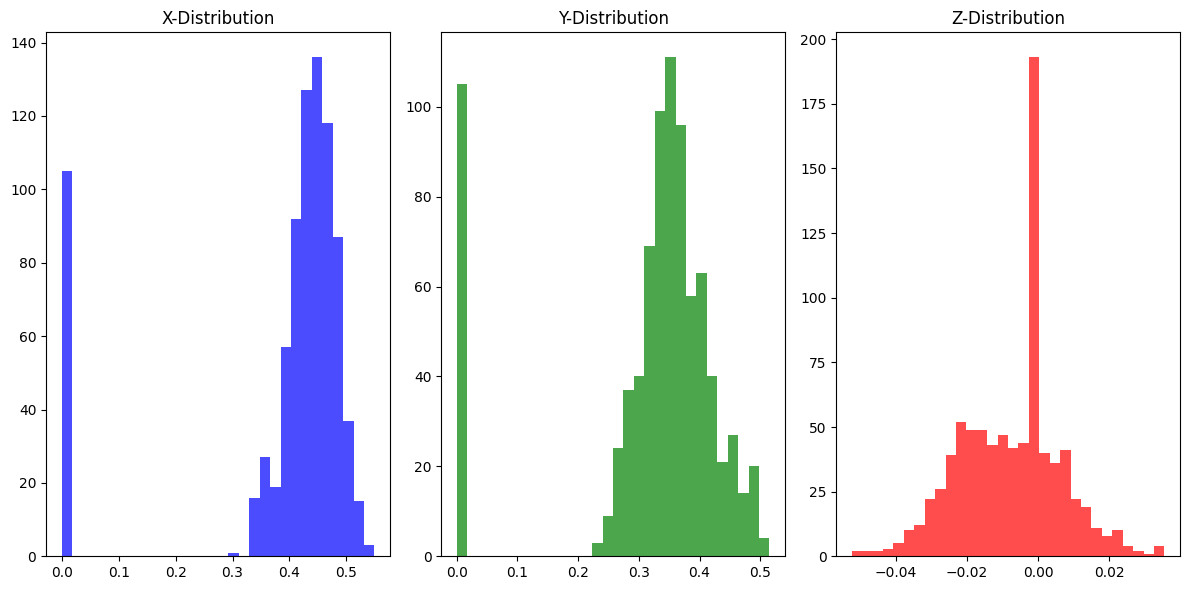

13


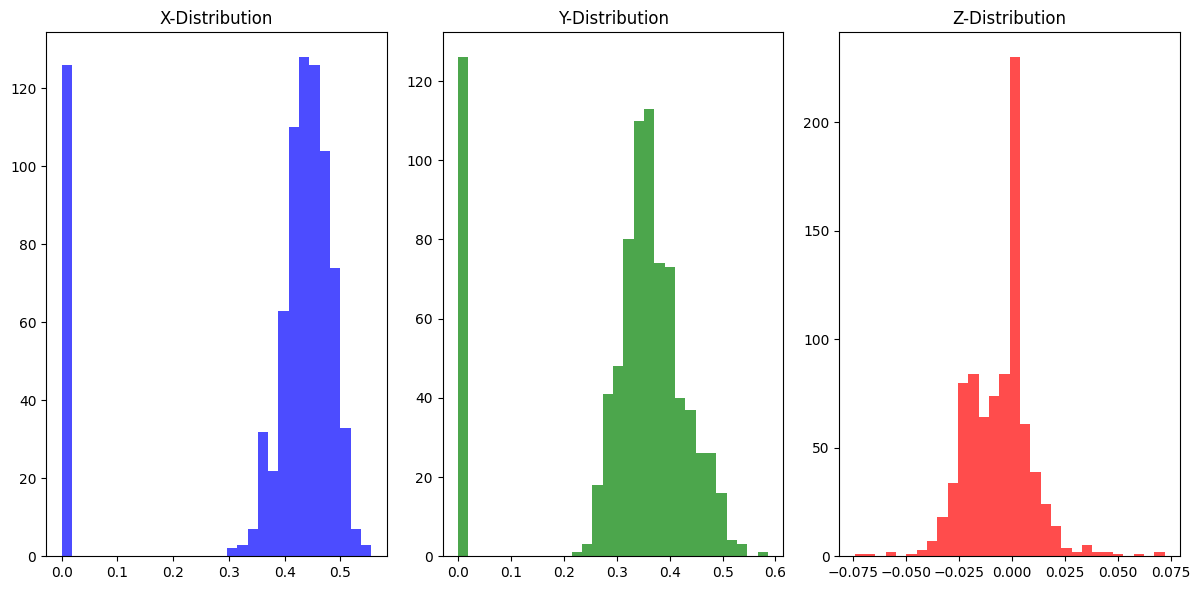

14


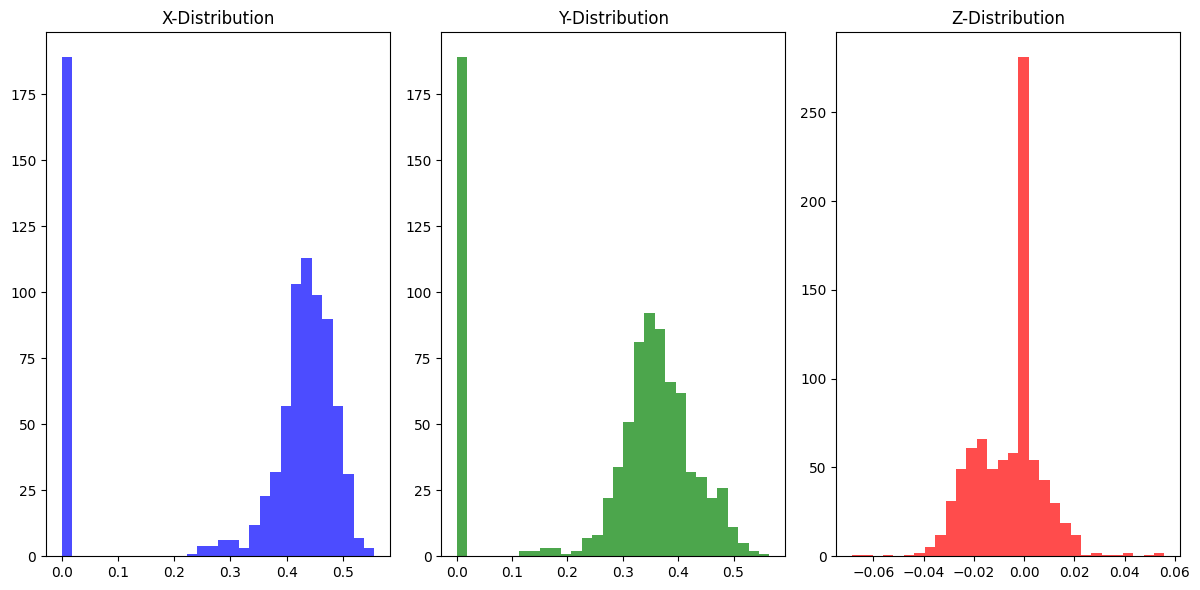

15


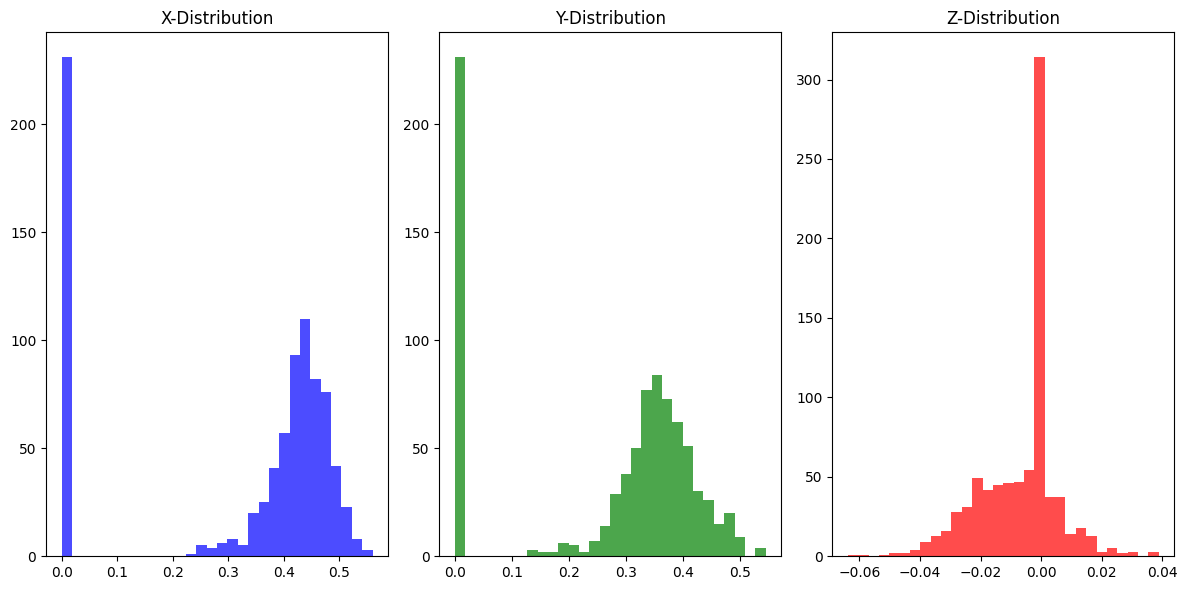

16


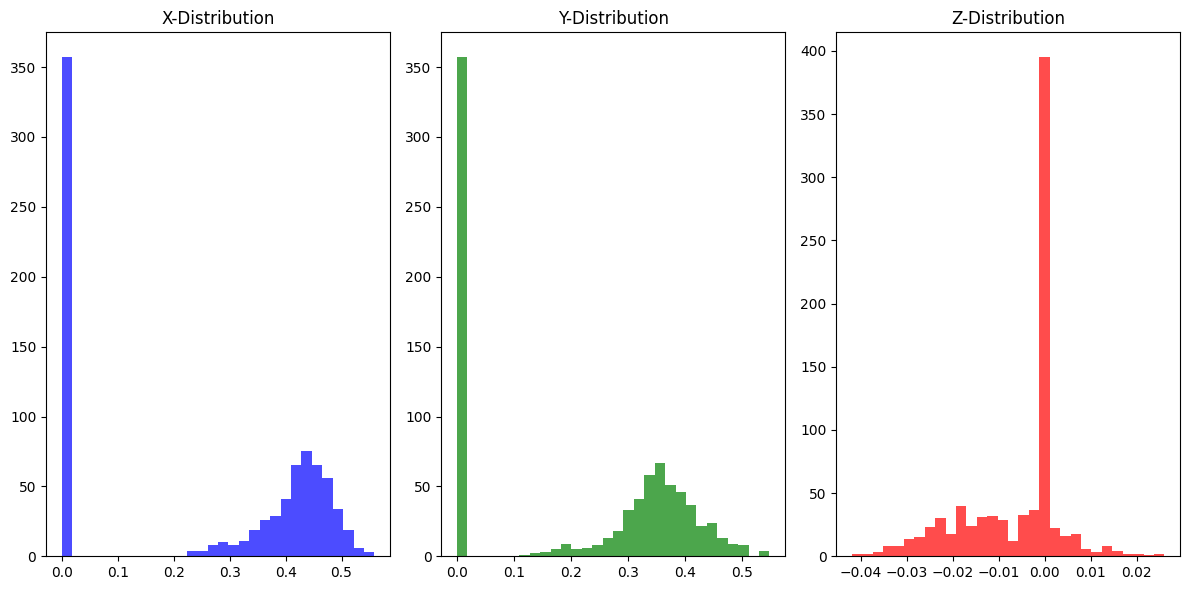

17


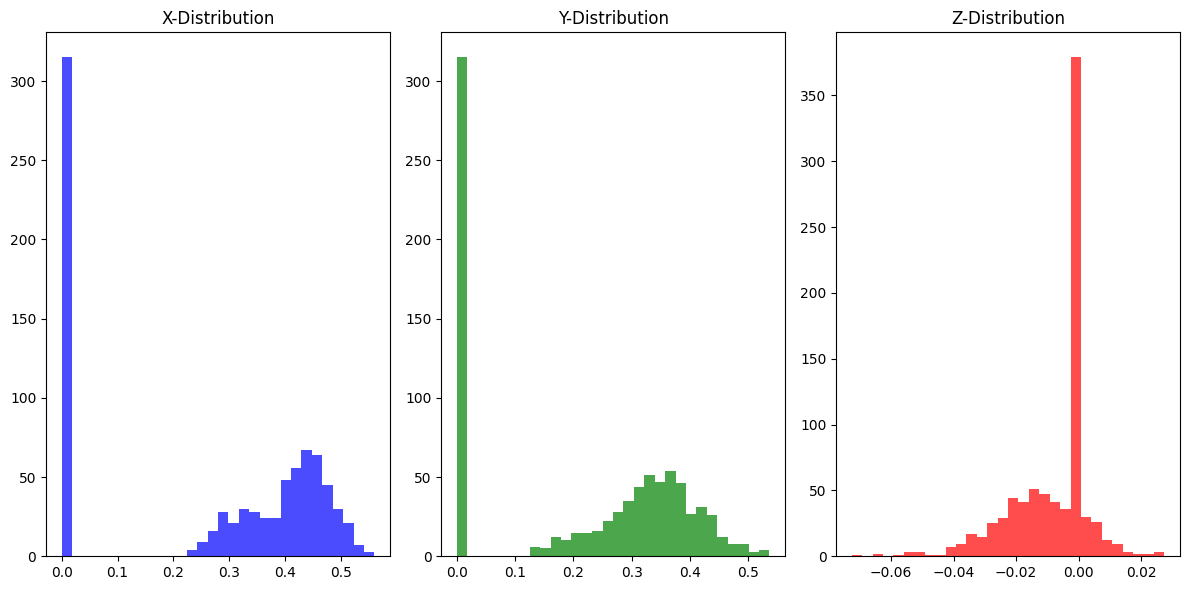

18


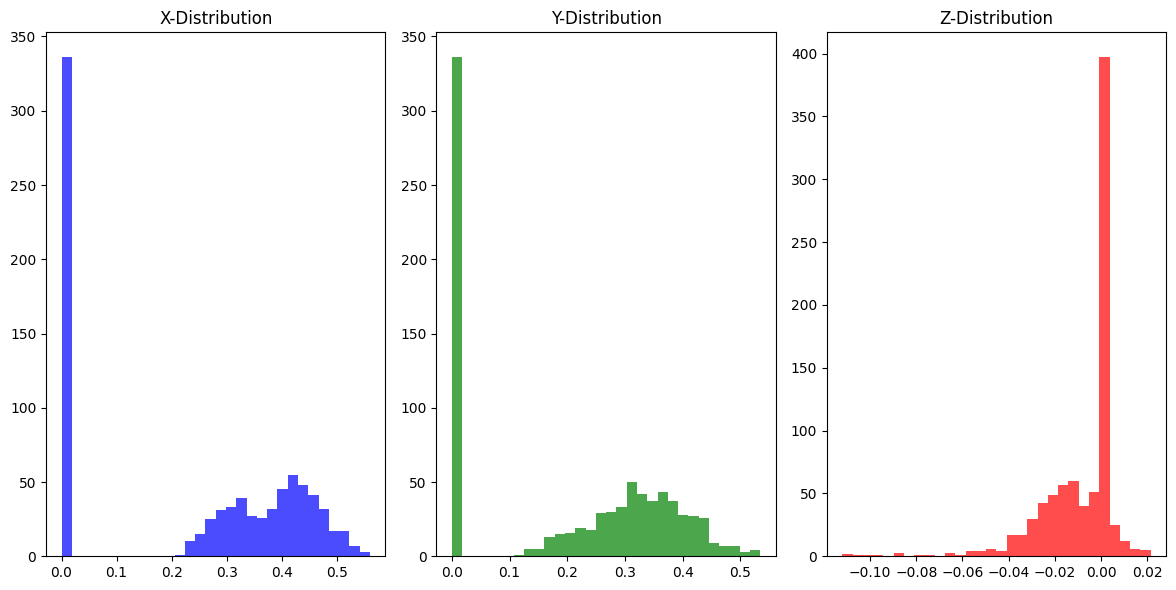

19


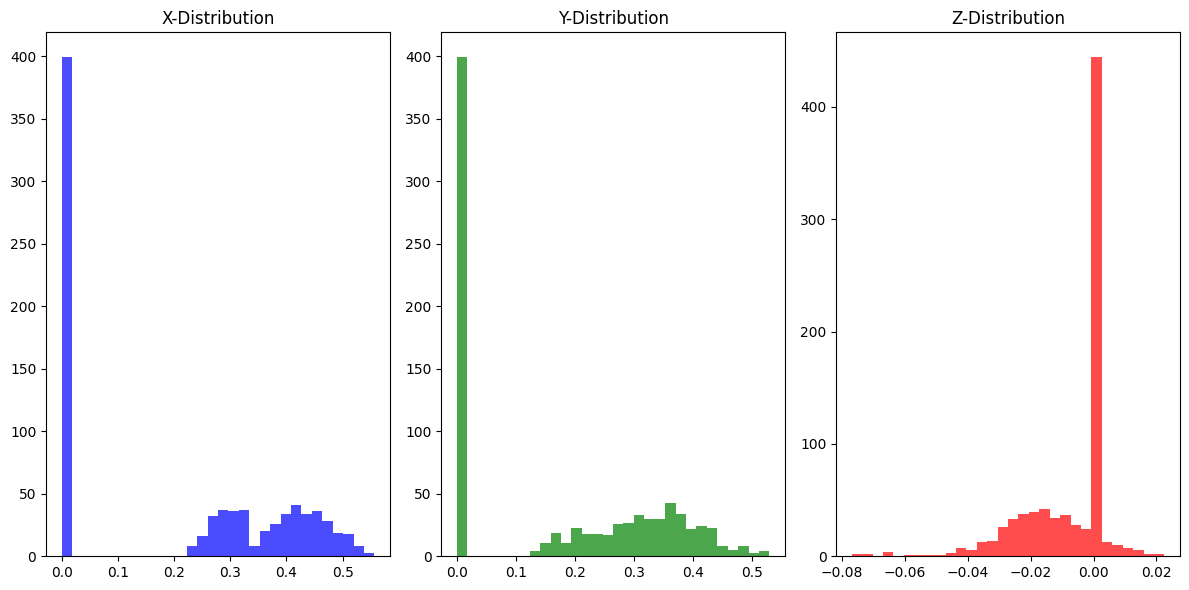

20


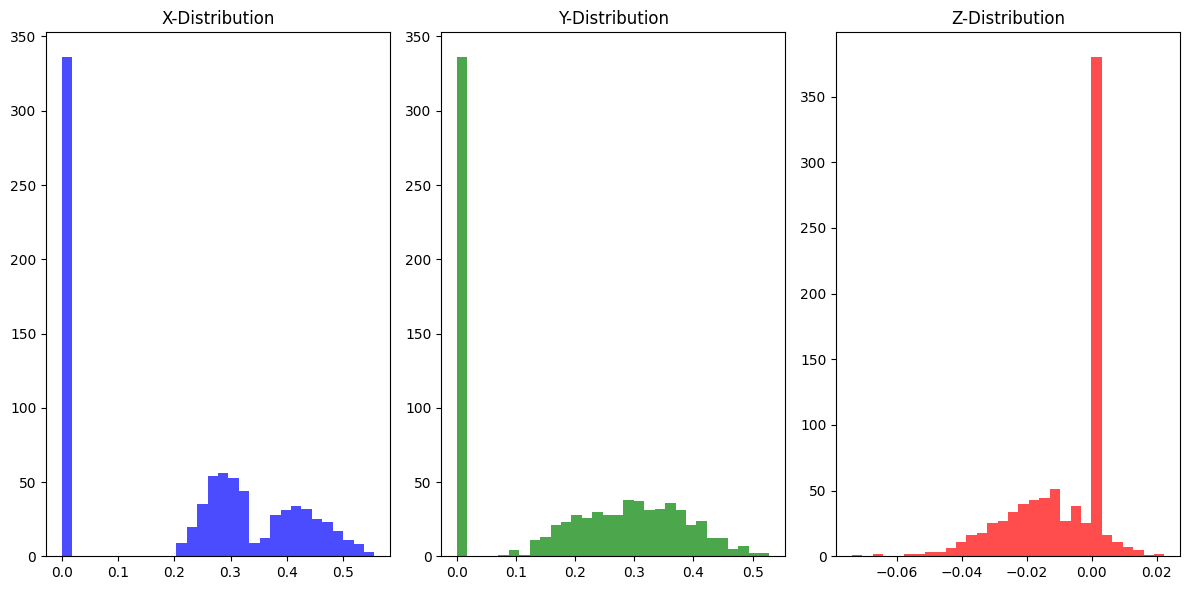

21


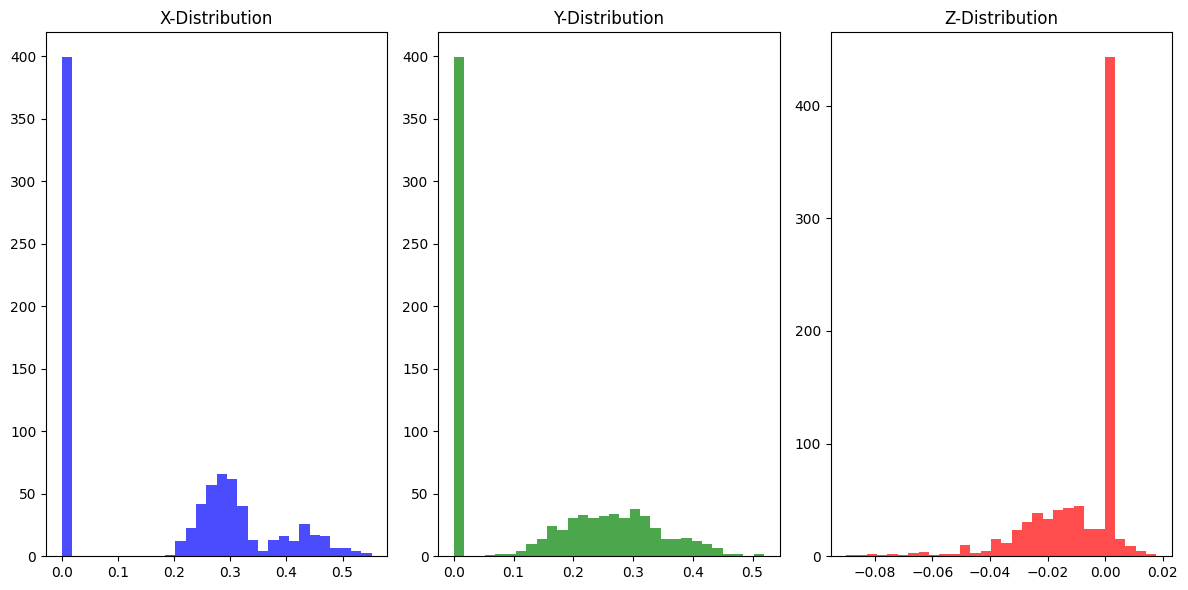

22


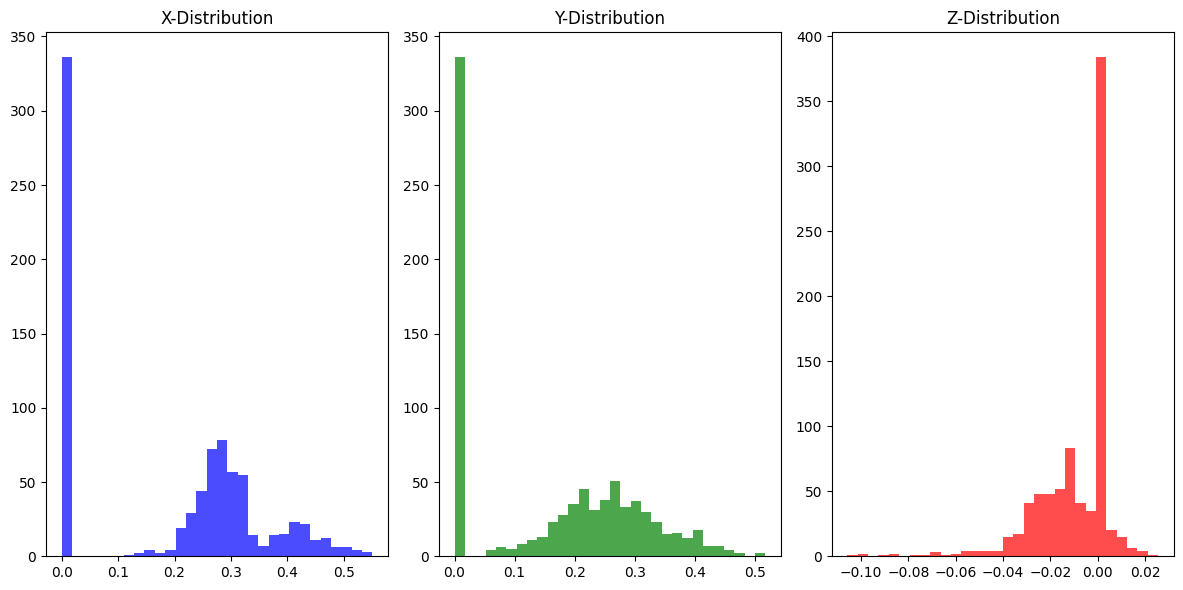

23


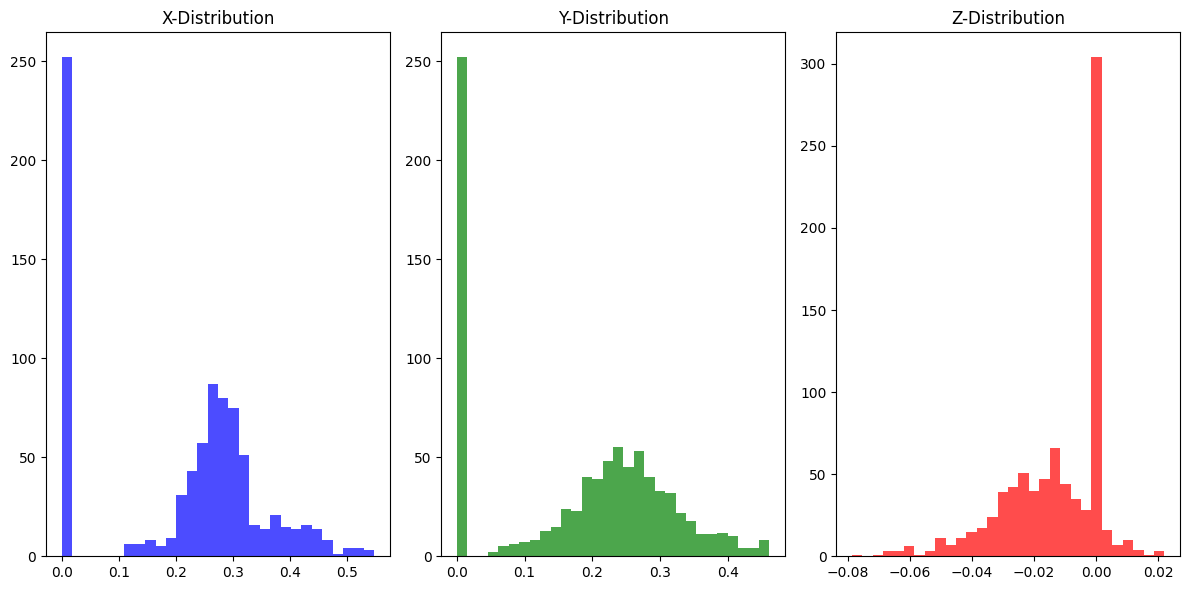

24


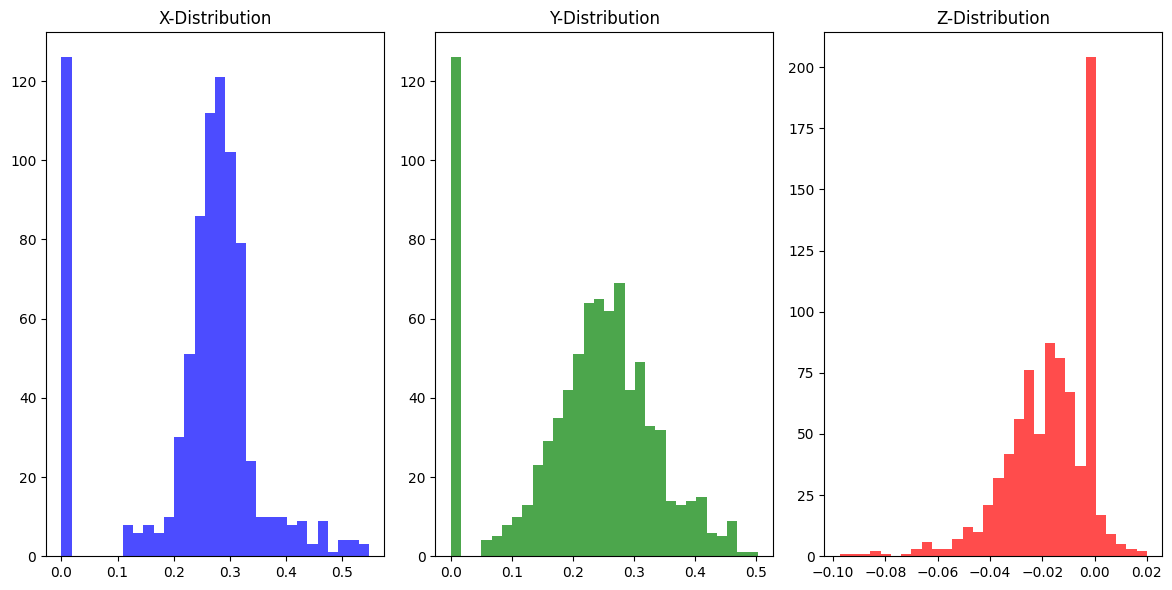

25


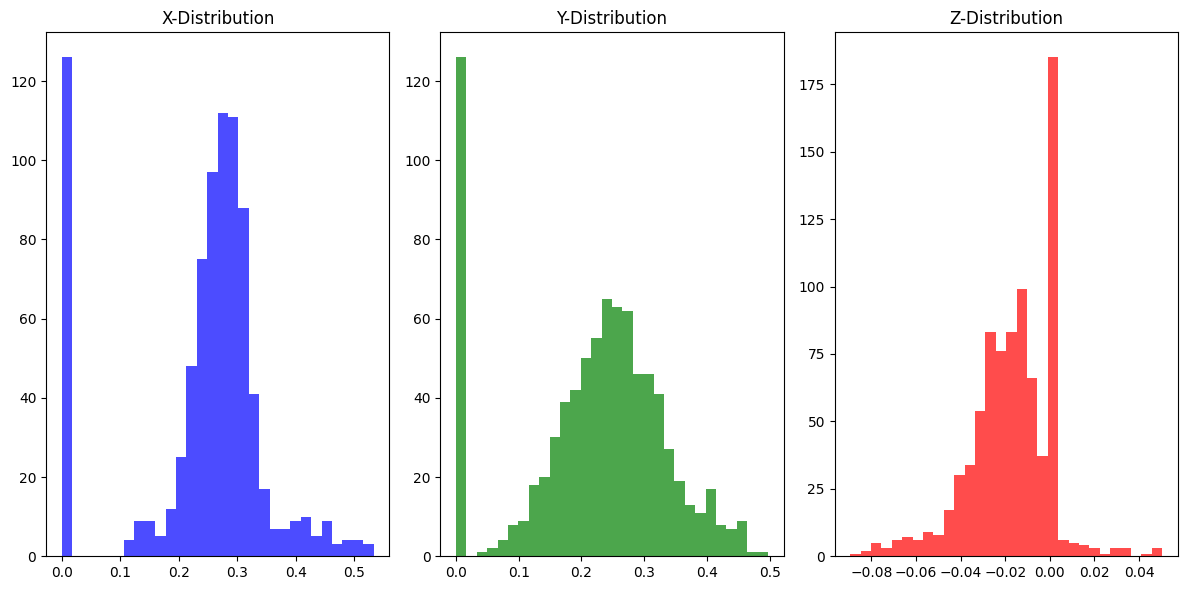

26


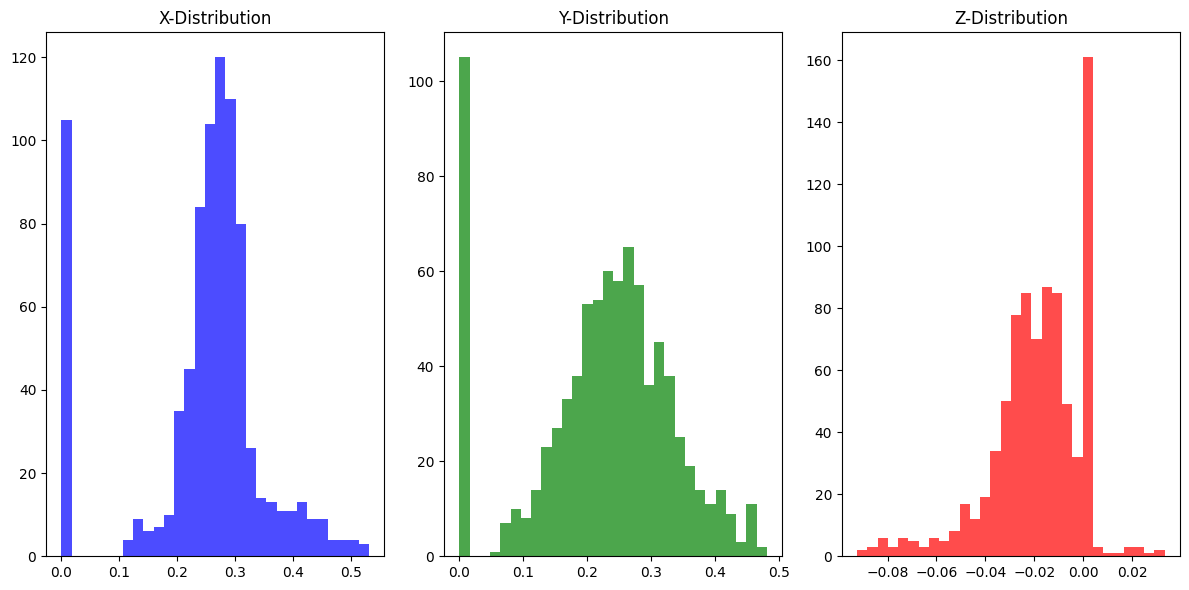

27


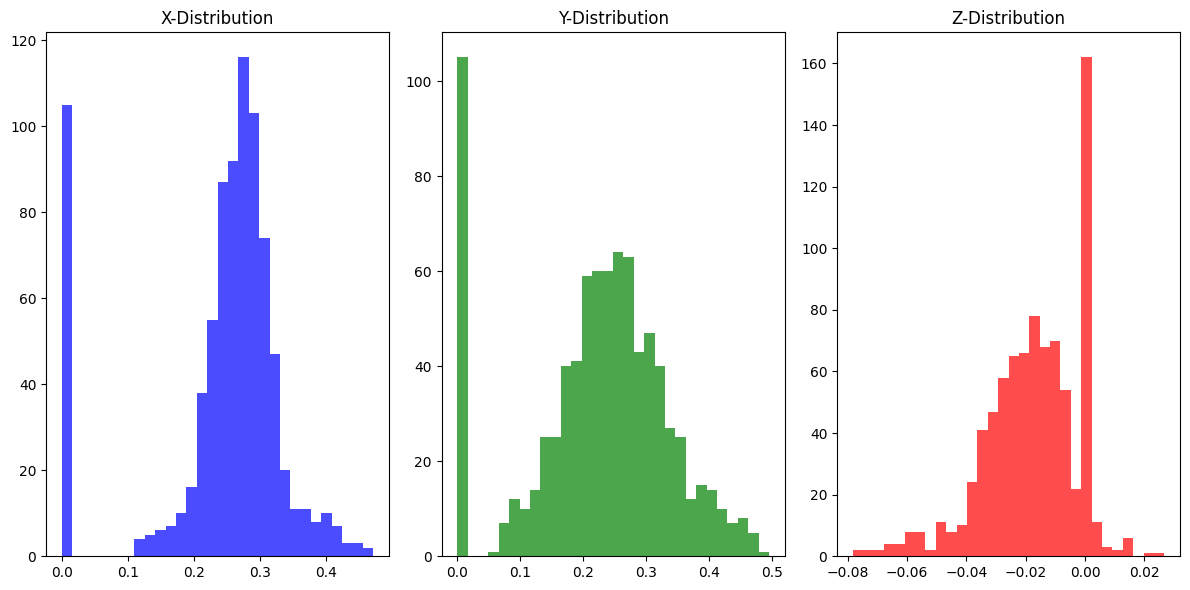

28


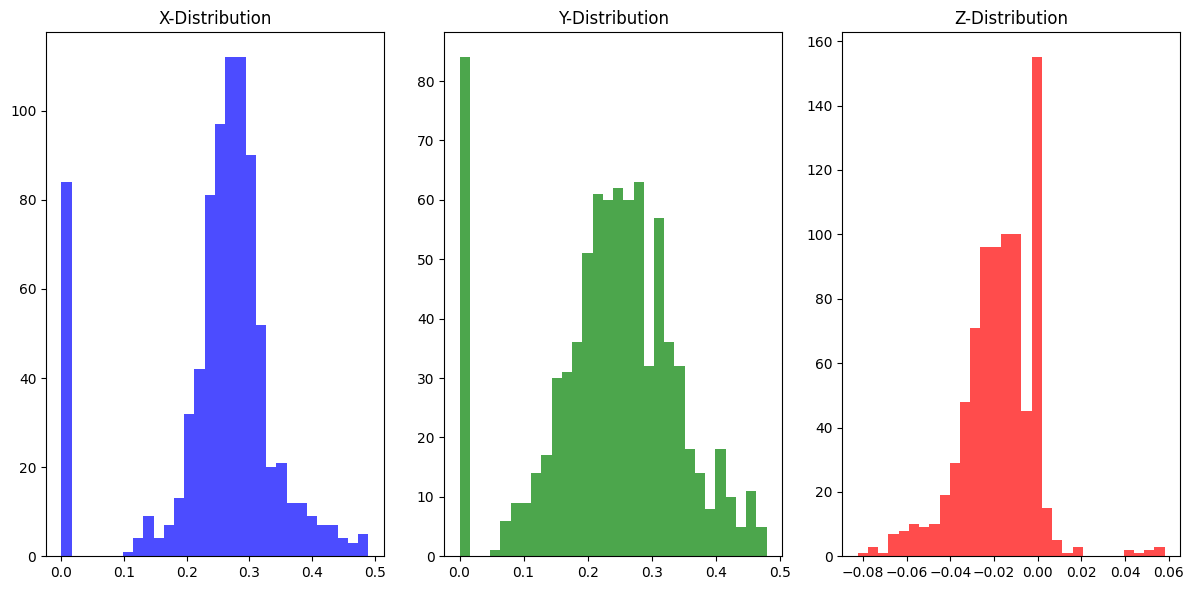

29


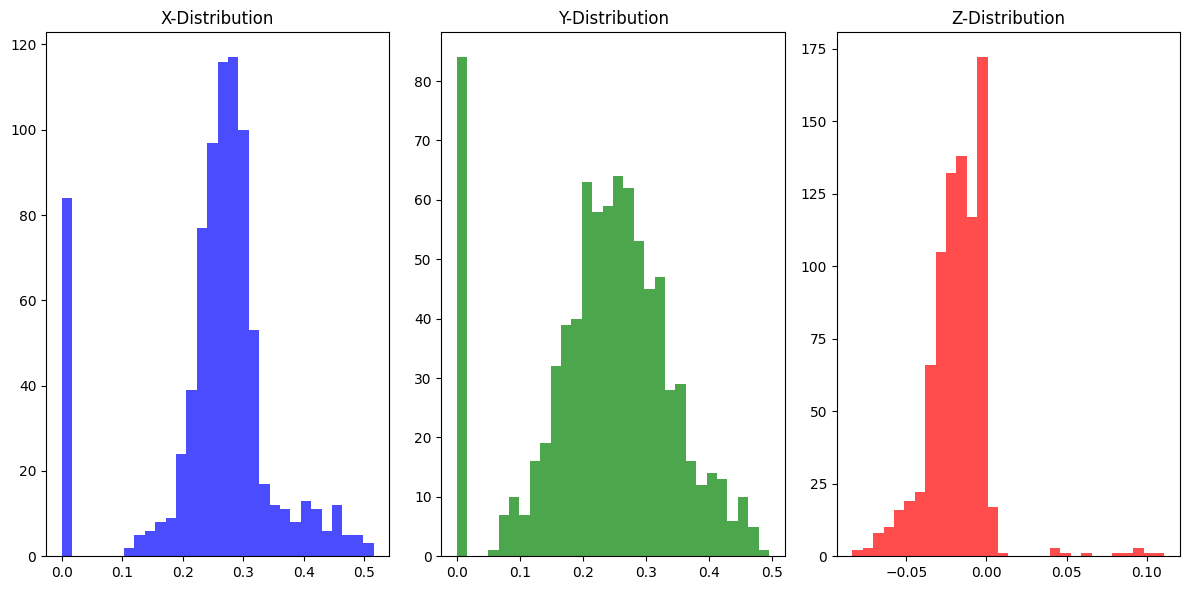

In [ ]:
# Distribution of every video, every frame by x, y, and z coordinate, but only pose landmarks
for i in range(0,30):
  print(i)
  mpkeys_cX = X_mpkeys[:,i,54:,0].reshape(-1)
  mpkeys_cY = X_mpkeys[:,i,54:,1].reshape(-1)
  mpkeys_cZ = X_mpkeys[:,i,54:,2].reshape(-1)
  plot_xyzDist(mpkeys_cX,mpkeys_cY,mpkeys_cZ)

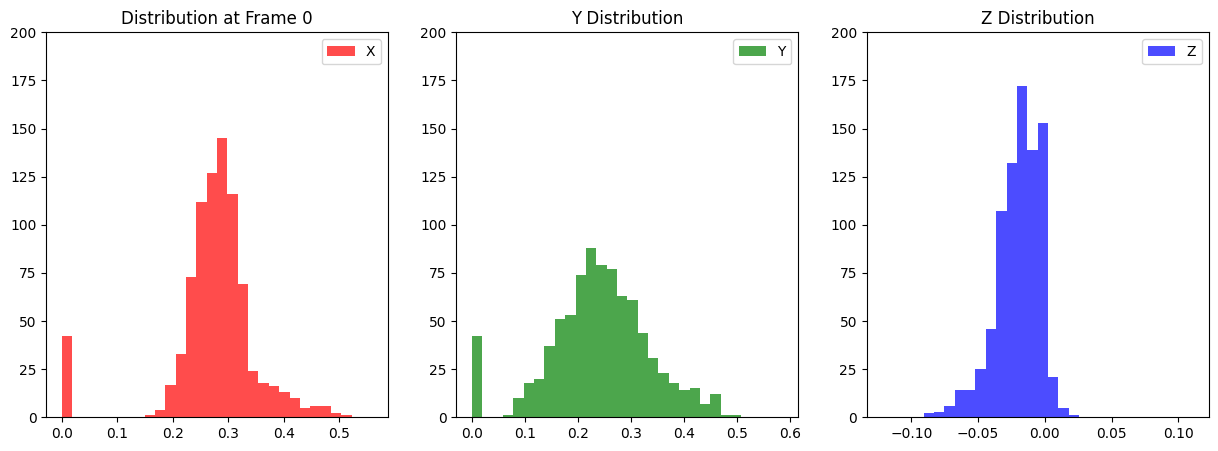

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

min_x = np.min(X_mpkeys[:, :, 54:, 0])
max_x = np.max(X_mpkeys[:, :, 54:, 0])
min_y = np.min(X_mpkeys[:, :, 54:, 1])
max_y = np.max(X_mpkeys[:, :, 54:, 1])
min_z = np.min(X_mpkeys[:, :, 54:, 2])
max_z = np.max(X_mpkeys[:, :, 54:, 2])

y_limit = 200
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

def plot_xyzDist(ax, x, y, z):
    ax = axs[0]
    ax.clear()
    ax.hist(x, bins=30, range=(min_x, max_x), color='red', alpha=0.7, label='X')
    ax.set_title('X Distribution')
    ax.set_ylim(0, y_limit)
    ax.legend()

    ax = axs[1]
    ax.clear()
    ax.hist(y, bins=30, range=(min_y, max_y), color='green', alpha=0.7, label='Y')
    ax.set_title('Y Distribution')
    ax.set_ylim(0, y_limit)
    ax.legend()

    ax = axs[2]
    ax.clear()
    ax.hist(z, bins=30, range=(min_z, max_z), color='blue', alpha=0.7, label='Z')
    ax.set_title('Z Distribution')
    ax.set_ylim(0, y_limit)
    ax.legend()


def update(frame):
    mpkeys_cX = X_mpkeys[:, frame, 54:, 0].reshape(-1)
    mpkeys_cY = X_mpkeys[:, frame, 54:, 1].reshape(-1)
    mpkeys_cZ = X_mpkeys[:, frame, 54:, 2].reshape(-1)

    plot_xyzDist(axs[0], mpkeys_cX, mpkeys_cY, mpkeys_cZ)
    axs[0].set_title(f'Distribution at Frame {frame}')

# Create the animation
animation = FuncAnimation(fig, update, frames=30, interval=200, blit=False)

# Display the animation in Colab
html = HTML(animation.to_jshtml())
display(html)


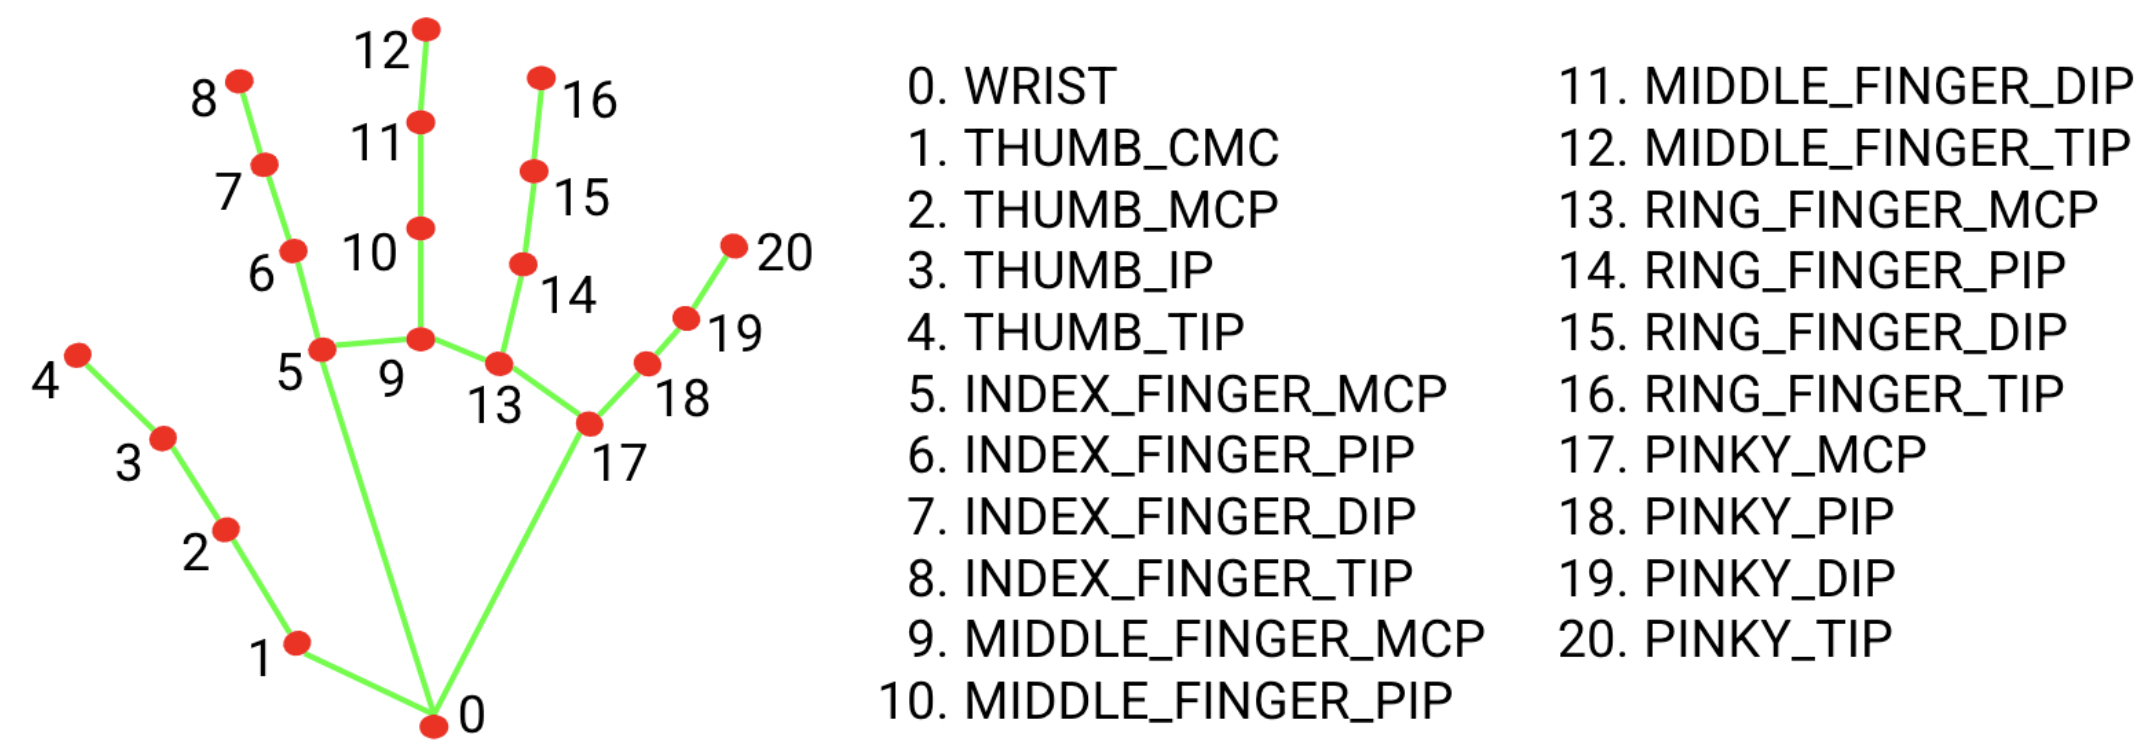
## Try plotting "0" landmark of the right hand

In [ ]:
mpkeys_cX = X_mpkeys[:,:,54,0]
mpkeys_cY = X_mpkeys[:,:,54,1]

In [ ]:
mpkeys_cX.shape

(40, 30)

In [ ]:
X_mpkeys[10,:,54,0].shape

(30,)

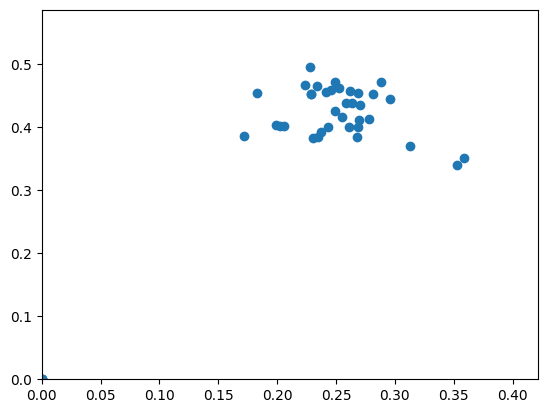

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

# Assuming you have two arrays representing X and Y coordinates
# Replace these with your actual data
x_coordinates = X_mpkeys[:,:,54,0]
y_coordinates = X_mpkeys[:,:,54,1]

fig, ax = plt.subplots()

# Set the limits for the plot
ax.set_xlim(np.min(x_coordinates), np.max(x_coordinates))
ax.set_ylim(np.min(y_coordinates), np.max(y_coordinates))

# Create an empty plot
points, = ax.plot([], [], 'o')

def update(frame):
    # Update the plot for each frame
    points.set_data(x_coordinates[:, frame], y_coordinates[:, frame])
    return points,

# Create the animation
animation = FuncAnimation(fig, update, frames=30, interval=200, blit=True)

# Display the animation in Colab
html = HTML(animation.to_jshtml())
display(html)